In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
import os

os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

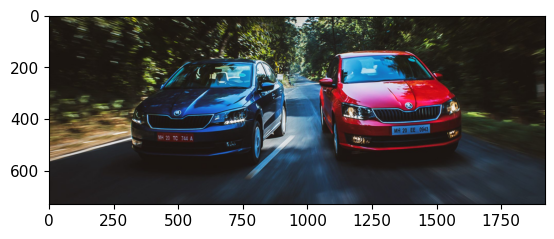

In [24]:
img =cv2.imread("./images/cars_license.jpg")
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
img_copy=img.copy()

In [25]:
#model trained for deducting car license plates.
licensemodel=torch.hub.load("ultralytics/yolov5","custom","./MODELS/best.pt")


Using cache found in C:\Users\nidhi/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-16 Python-3.8.10 torch-2.0.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


image 1/1: 730x1920 2 licenses
Speed: 7.0ms pre-process, 196.2ms inference, 0.0ms NMS per image at shape (1, 3, 256, 640)


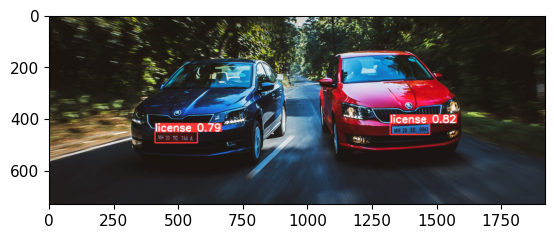

In [26]:
results=licensemodel(img)
results.print()
plt.imshow(np.squeeze(results.render()))



In [27]:
lic_xyxy=results.pandas().xyxy[0]
lic_xyxy

,xmin,ymin,xmax,ymax,confidence,class,name
0,1320.325562,417.318512,1473.014893,461.083649,0.823650,0,license
1,410.294037,450.203064,574.292908,493.546600,0.787832,0,license


license


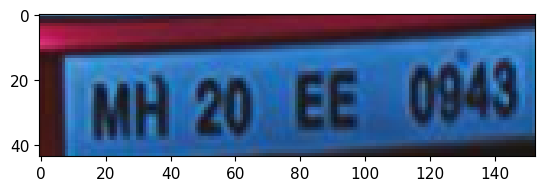

license


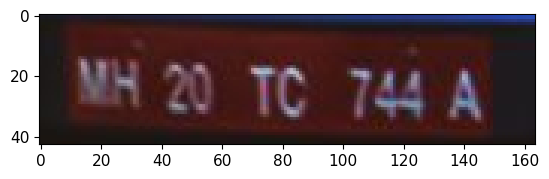

In [30]:
for i in range(len(lic_xyxy)):
    print(lic_xyxy['name'][i])
    plt.imshow(img_copy[int(lic_xyxy['ymin'][i]):int(lic_xyxy['ymax'][i]),int(lic_xyxy['xmin'][i]):int(lic_xyxy['xmax'][i])])
    plt.show()

In [32]:
#Now we will use pretrained model to deduct characters from the license  plates

#Predefined OCR(optical character recognition)
#- easyocr
#- predeined yolo model
#- 
!pip install easyocr

  Using cached easyocr-1.6.2-py3-none-any.whl (2.9 MB)
  Using cached pyclipper-1.3.0.post4-cp38-cp38-win_amd64.whl (95 kB)
  Using cached ninja-1.11.1-py2.py3-none-win_amd64.whl (313 kB)
  Using cached opencv_python_headless-4.5.4.60-cp38-cp38-win_amd64.whl (35.0 MB)
  Using cached python_bidi-0.4.2-py2.py3-none-any.whl (30 kB)
  Using cached shapely-2.0.1-cp38-cp38-win_amd64.whl (1.4 MB)


In [34]:
from easyocr import Reader
img2Text=Reader(['en'])

CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


In [43]:
#YOLO custom Pre trained model for OCR

model_yolo_ocr=torch.hub.load("ultralytics/yolov5","custom","./MODELS/ocr_best.pt")

Using cache found in C:\Users\nidhi/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-2-16 Python-3.8.10 torch-2.0.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7109914 parameters, 0 gradients, 16.1 GFLOPs
Adding AutoShape... 


license
MH 20 Ee40249


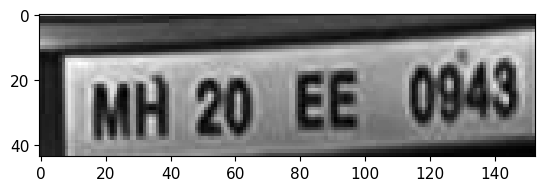

YOLO model result:  ['M', 'H', '2', '0', 'E', 'E', '0', '8', '4', '9', '1']
license
VH 2 Tc 744 A


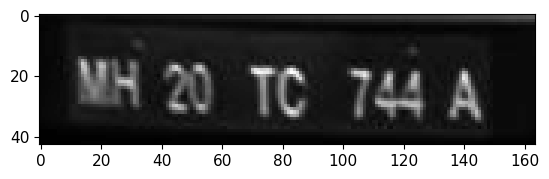

YOLO model result:  ['H', 'ARABIC', '2', 'D', 'ARABIC', 'C', '7', '4', 'A']


In [52]:

for i in range(len(lic_xyxy)):
    print(lic_xyxy['name'][i])
    plate=img_copy[int(lic_xyxy['ymin'][i]):int(lic_xyxy['ymax'][i]),int(lic_xyxy['xmin'][i]):int(lic_xyxy['xmax'][i])]
    plategray=cv2.cvtColor(plate,cv2.COLOR_RGB2GRAY)
   # alllabel=img2Text.readtext(plategray)
    #label=img2Text.readtext(plate)[0][1]
    labelgray=img2Text.readtext(plategray)[0][1]
    #print(label)
    print(labelgray)
    plt.imshow(plategray,cmap='gray')
    plt.show()
    
    
    res_ocr=model_yolo_ocr(plate)
    chardf=res_ocr.pandas().xyxy[0]
    sorted_char=chardf.sort_values('xmin')
    list(sorted_char['name'])
    print('YOLO model result: ',list(sorted_char['name']))

In [73]:
#!pip install transformers

     ---------------------------------------- 6.8/6.8 MB 12.0 MB/s eta 0:00:00
  Using cached regex-2023.3.23-cp38-cp38-win_amd64.whl (267 kB)
  Using cached tokenizers-0.13.2-cp38-cp38-win_amd64.whl (3.3 MB)
  Using cached huggingface_hub-0.13.3-py3-none-any.whl (199 kB)


In [74]:
#Transformers architecture used in NLP
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
printed_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
printed_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# from transformers import TrOCRProcessor,VisionEncoderDecoderModel
# printed_processor=TrOCRProcessor.from_pretrained('microsoft/trocr-base-printed')
# printed-model=VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-printed')

# def ocr_printed_image(src_img,printed_processor,printed-model)
#     pixel_values

In [80]:
def ocr_printed_image(src_img,printed_processor,printed_model):
  pixel_values = printed_processor(images=src_img, return_tensors="pt").pixel_values
  generated_ids = printed_model.generate(pixel_values)
  return printed_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [84]:
import keras_ocr

In [88]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\nidhi\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\nidhi\.keras-ocr\crnn_kurapan.h5


In [87]:
#!pip install keras-ocr

license
Easy OCR: MH 20 Ee40249
YOLO model result:  M H 2 0 E E 0 8 4 9 1
TrOCR Result:  MH 20 EE 0943


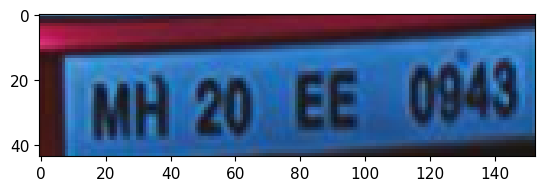

license
Easy OCR: VH 2 Tc 744 A
YOLO model result:  H ARABIC 2 D ARABIC C 7 4 A
TrOCR Result:  NH 20 TC 744 A


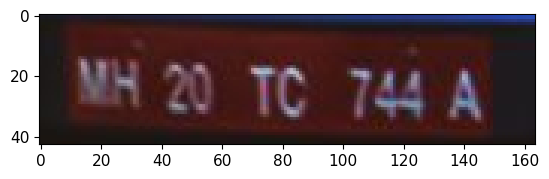

In [98]:
licensedir="./images/LicensePlates/"
for i in range(len(lic_xyxy)):
    print(lic_xyxy['name'][i])
    plate=img_copy[int(lic_xyxy['ymin'][i]):int(lic_xyxy['ymax'][i]),int(lic_xyxy['xmin'][i]):int(lic_xyxy['xmax'][i])]
    plategray=cv2.cvtColor(plate,cv2.COLOR_RGB2GRAY)
    #label_ocr=img2Text.readtext(plate)[0][1]
    labelgray_ocr=img2Text.readtext(plategray)[0][1]
    #print(label)
    print("Easy OCR:",labelgray_ocr)
    
    
    res_ocr=model_yolo_ocr(plate)
    chardf=res_ocr.pandas().xyxy[0]
    sorted_char_df=chardf.sort_values('xmin')
    labellist=list(sorted_char_df['name'])
    labelstr_yolo=' '.join(map(str,labellist))
    #list(sorted_char['name'])
    print('YOLO model result: ',labelstr_yolo)
    
    label_trocr=ocr_printed_image(plate,printed_processor,printed_model)
    print('TrOCR Result: ',label_trocr)
    
    loc=licensedir+'plate'+str(i)+'.jpg'
    cv2.imwrite(loc,plate)
    
    plt.imshow(plate)
    plt.show()
   

In [107]:
# images = [
#     keras_ocr.tools.read(img) for img in [
#         "./images/LicensePlates/plate0.jpg",
#         "./images/LicensePlates/plate1.jpg"
#     ]
# ]

images = [
    keras_ocr.tools.read(img) for img in [
       "./images/cars_license.jpg",
       "./images/text_img1.jpg",
       "./images/text_img2.jpg"
    ]
]

Looking for C:\Users\nidhi\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\nidhi\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 53s 53s/step


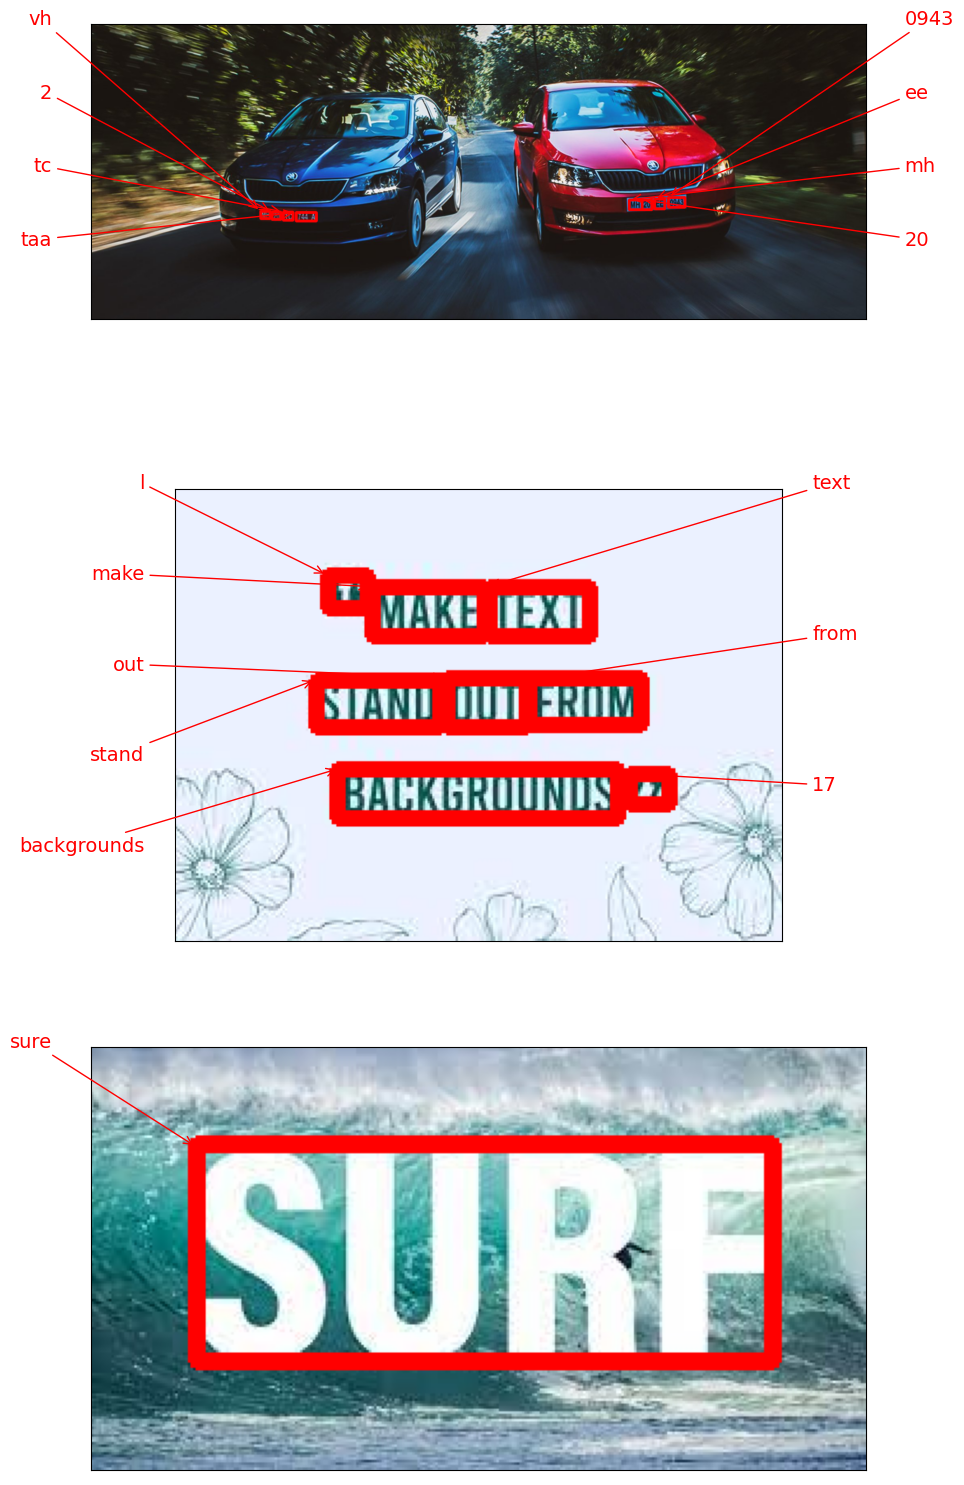

In [108]:
pipeline = keras_ocr.pipeline.Pipeline()
prediction_groups = pipeline.recognize(images)
    
   # Plot the predictions
    
fig, axs = plt.subplots(nrows=len(images), figsize=(10, 20))
for ax, image, predictions in zip(axs, images, prediction_groups):
    keras_ocr.tools.drawAnnotations(image=image, 
                                    predictions=predictions, 
                                    ax=ax)
    

    

In [106]:
predicted_image = prediction_groups[0]
for text, box in predicted_image:
    print(text)

0943
ee
mh
20
vh
2
tc
taa
